Loading Data...
Setting up Preprocessing...
Starting Grid Search (CatBoost)...
[1/24] ACC=0.8901 | REC=0.6963 | F1=0.6625 | F2=0.6824 | ROC=0.9278 | PR=0.7376depth=4, lr=0.01, iters=500 | OOF_F1=0.6933 thr=0.749 |
[2/24] ACC=0.8901 | REC=0.7147 | F1=0.6683 | F2=0.6954 | ROC=0.9297 | PR=0.7425depth=4, lr=0.01, iters=1000 | OOF_F1=0.6944 thr=0.710 |
[3/24] ACC=0.8925 | REC=0.6911 | F1=0.6658 | F2=0.6808 | ROC=0.9272 | PR=0.7393depth=4, lr=0.05, iters=500 | OOF_F1=0.6879 thr=0.719 |
[4/24] ACC=0.8852 | REC=0.7120 | F1=0.6578 | F2=0.6893 | ROC=0.9235 | PR=0.7261depth=4, lr=0.05, iters=1000 | OOF_F1=0.6791 thr=0.647 |
[5/24] ACC=0.8877 | REC=0.6885 | F1=0.6550 | F2=0.6747 | ROC=0.9254 | PR=0.7288depth=4, lr=0.1, iters=500 | OOF_F1=0.6770 thr=0.673 |
[6/24] ACC=0.8848 | REC=0.7277 | F1=0.6619 | F2=0.6999 | ROC=0.9224 | PR=0.7218depth=4, lr=0.1, iters=1000 | OOF_F1=0.6689 thr=0.568 |
[7/24] ACC=0.8889 | REC=0.7173 | F1=0.6667 | F2=0.6961 | ROC=0.9305 | PR=0.7473depth=6, lr=0.01, iters=500 | O

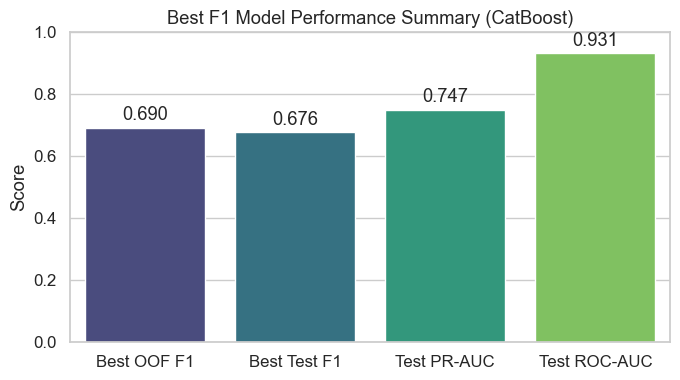

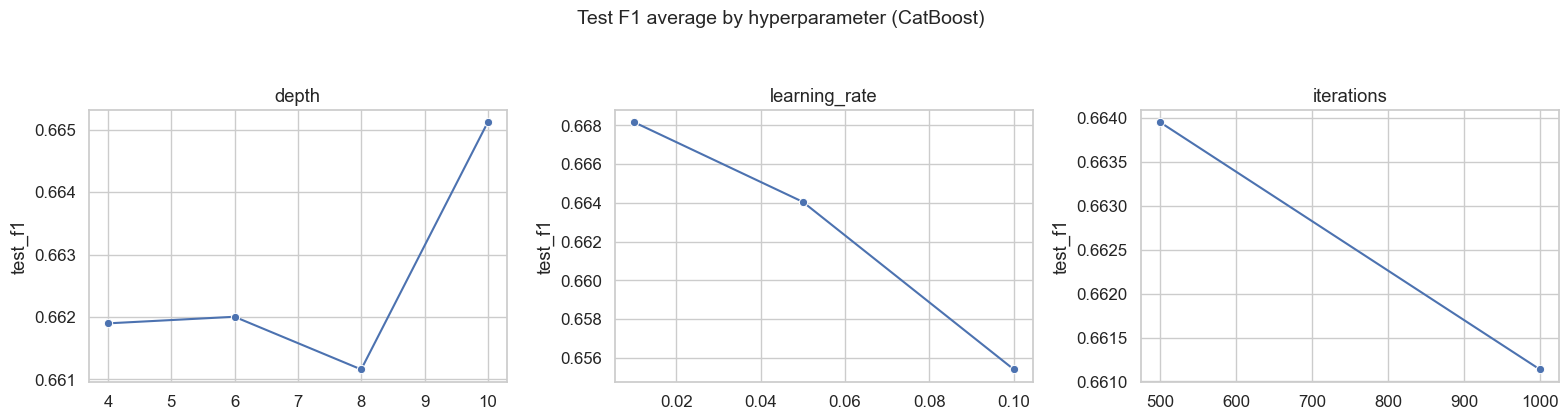

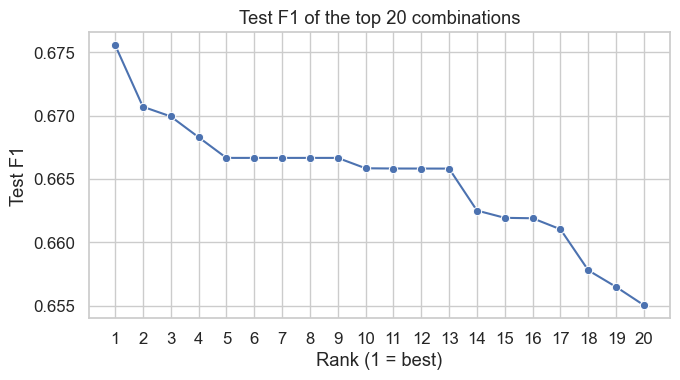


[TOP-K PARAMS] Preview of the top F1 combinations:
    test_f1   test_f2  test_pr_auc  depth  learning_rate  iterations
0  0.675577  0.705942     0.747328     10           0.01         500
1  0.670702  0.702333     0.744330      8           0.01         500
2  0.669939  0.696073     0.750507      6           0.01        1000
3  0.668299  0.695364     0.742495      4           0.01        1000
4  0.666667  0.685670     0.728172     10           0.10         500
5  0.666667  0.679587     0.733134     10           0.05         500
6  0.666667  0.696138     0.747294      6           0.01         500
7  0.666667  0.685670     0.737688      6           0.05         500
8  0.666667  0.687179     0.728464      6           0.05        1000
9  0.665848  0.691327     0.737288      8           0.05         500


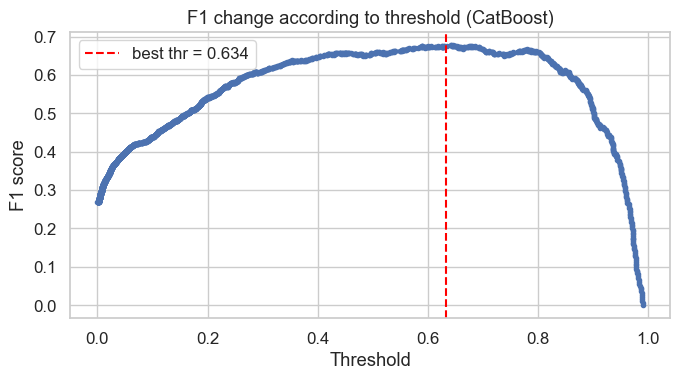


[Test Metrics] F2-Score (beta=2, thr=0.634): 0.7059


In [4]:
# =====================================
# 📊 F2 Score Optimization & Visualization (CatBoost Version)
# =====================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score, roc_auc_score, fbeta_score, accuracy_score, recall_score

sns.set(style="whitegrid", font_scale=1.1)

# -----------------------------
# 1. Configuration & Data Loading
# -----------------------------
TRAIN_PATH = "../../data/processed/train.csv"
TEST_PATH  = "../../data/processed/test.csv"
TARGET_COL = "Revenue"
RANDOM_STATE = 42
N_SPLITS = 5

print("Loading Data...")
try:
    train_df = pd.read_csv(TRAIN_PATH)
    test_df  = pd.read_csv(TEST_PATH)
except FileNotFoundError:
    import os
    print(f"Data not found at {TRAIN_PATH}. Checking current directory...")
    # Assuming script is run from notebooks/EomHyungEun/
    raise FileNotFoundError("Please ensure train.csv and test.csv are in ../../data/processed/")

X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL].astype(int)
X_test  = test_df.drop(columns=[TARGET_COL])
y_test  = test_df[TARGET_COL].astype(int)

# -----------------------------
# 2. Preprocessing
# -----------------------------
print("Setting up Preprocessing...")
# Note: CatBoost can handle categorical features natively, but for consistency 
# with the existing pipeline structure and robust scaling, we maintain the ColumnTransformer.
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

# -----------------------------
# 3. Helper Functions
# -----------------------------
def oof_proba_for_pipe(pipe, X, y, n_splits=5, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = np.zeros(len(X), dtype=float)
    for tr_idx, va_idx in skf.split(X, y):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va = X.iloc[va_idx]
        pipe.fit(X_tr, y_tr)
        oof[va_idx] = pipe.predict_proba(X_va)[:, 1]
    return oof

def best_f1_threshold(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
    best_idx = int(np.nanargmax(f1s))
    best_thr = float(thr[best_idx - 1]) if best_idx > 0 else 0.5
    return best_thr, float(f1s[best_idx])

# -----------------------------
# 4. Model Training & Grid Search (CatBoost)
# -----------------------------
print("Starting Grid Search (CatBoost)...")

# CatBoost Grid
grid = []
for depth in [4, 6, 8, 10]:
    for learning_rate in [0.01, 0.05, 0.1]:
        for iterations in [500, 1000]:
            grid.append({
                "depth": depth,
                "learning_rate": learning_rate,
                "iterations": iterations,
                "auto_class_weights": "Balanced", 
                "verbose": 0,
                "allow_writing_files": False
            })

best = None
results = []

total_iter = len(grid)
for i, params in enumerate(grid, 1):
    # Initialize CatBoost
    model = CatBoostClassifier(
        depth=params["depth"],
        learning_rate=params["learning_rate"],
        iterations=params["iterations"],
        auto_class_weights=params["auto_class_weights"],
        verbose=params["verbose"],
        allow_writing_files=params["allow_writing_files"],
        random_seed=RANDOM_STATE
    )
    
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])

    # OOF
    oof = oof_proba_for_pipe(pipe, X_train, y_train, n_splits=N_SPLITS, seed=RANDOM_STATE)
    thr, oof_f1 = best_f1_threshold(y_train, oof)

    # Train on full train
    pipe.fit(X_train, y_train)
    test_proba = pipe.predict_proba(X_test)[:, 1]
    
    # Eval
    test_pred = (test_proba >= thr).astype(int)
    test_acc = float(accuracy_score(y_test, test_pred))
    test_rec = float(recall_score(y_test, test_pred))
    test_f1 = float(f1_score(y_test, test_pred))
    test_f2 = fbeta_score(y_test, test_pred, beta=2)
    
    current_result = {
        **params,
        "thr": thr,
        "oof_f1": oof_f1,
        "test_acc": test_acc,
        "test_rec": test_rec,
        "test_f1": test_f1,
        "test_f2": test_f2,
        "test_pr_auc": float(average_precision_score(y_test, test_proba)),
        "test_roc_auc": float(roc_auc_score(y_test, test_proba)),
    }
    results.append(current_result)
    
    if best is None or test_f1 > best["test_f1"]:
        best = current_result.copy()
        best["params"] = params
    
    print(f"[{i}/{total_iter}] ACC={test_acc:.4f} | REC={test_rec:.4f} | F1={test_f1:.4f} | F2={test_f2:.4f} |"
          f" ROC={current_result['test_roc_auc']:.4f} | PR={current_result['test_pr_auc']:.4f}"
          f"depth={params['depth']}, lr={params['learning_rate']}, "
          f"iters={params['iterations']} | OOF_F1={oof_f1:.4f} thr={thr:.3f} |")

print("\n=== BEST CONFIG (by TEST F1) ===")
print(best)

# -----------------------------
# 5. Visualization & F2 Score
# -----------------------------
print("\nGenerating Visualizations...")

results_df = pd.DataFrame(results)

# --- Plot 1: Best config performance ---
best_thr = best["thr"]
metrics_df = pd.DataFrame(
    {
        "metric": ["Best OOF F1", "Best Test F1", "Test PR-AUC", "Test ROC-AUC"],
        "value": [best["oof_f1"], best["test_f1"], best["test_pr_auc"], best["test_roc_auc"]],
    }
)

plt.figure(figsize=(7, 4))
ax = sns.barplot(data=metrics_df, x="metric", y="value", palette="viridis", legend=False, hue='metric')
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3)
plt.ylim(0, 1.0)
plt.title("Best F1 Model Performance Summary (CatBoost)")
plt.ylabel("Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

# --- Plot 2: Hyperparameter Effects ---
def plot_param_effects_f1(df, score_col="test_f1"):
    params_to_plot = ["depth", "learning_rate", "iterations"]
    n = len(params_to_plot)
    ncols = 3
    nrows = 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4))
    axes = axes.ravel()

    for ax, param in zip(axes, params_to_plot):
        if param not in df.columns:
            ax.set_visible(False)
            continue
        
        # simple numeric plot
        tmp = df.groupby(param)[score_col].mean().reset_index().sort_values(param)
        sns.lineplot(data=tmp, x=param, y=score_col, marker="o", ax=ax)
        
        ax.set_title(param)
        ax.set_ylabel(score_col)
        ax.set_xlabel("")
        
    plt.suptitle("Test F1 average by hyperparameter (CatBoost)", y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_param_effects_f1(results_df)

# --- Plot 3: Top K Ranking ---
k = 20
topk = results_df.sort_values("test_f1", ascending=False).head(k).reset_index(drop=True)

plt.figure(figsize=(7, 4))
sns.lineplot(x=topk.index + 1, y="test_f1", data=topk, marker="o")
plt.title(f"Test F1 of the top {k} combinations")
plt.xlabel("Rank (1 = best)")
plt.ylabel("Test F1")
plt.xticks(range(1, k + 1))
plt.tight_layout()
plt.show()

print("\n[TOP-K PARAMS] Preview of the top F1 combinations:")
display_cols = ["test_f1", "test_f2", "test_pr_auc", "depth", "learning_rate", "iterations"]
print(topk[display_cols].head(10))

# --- Plot 4: Threshold vs F1 Curve for Best Model ---
best_params = best["params"]
best_model = CatBoostClassifier(
    depth=best_params["depth"],
    learning_rate=best_params["learning_rate"],
    iterations=best_params["iterations"],
    auto_class_weights=best_params["auto_class_weights"],
    verbose=best_params["verbose"],
    allow_writing_files=best_params["allow_writing_files"],
    random_seed=RANDOM_STATE
)
best_pipe = Pipeline([("preprocess", preprocess), ("model", best_model)])
best_pipe.fit(X_train, y_train)

best_test_proba = best_pipe.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, best_test_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
thr_for_plot = np.r_[0.0, thr]

plt.figure(figsize=(7, 4))
plt.plot(thr_for_plot, f1s, marker=".")
plt.axvline(best_thr, color="red", linestyle="--", label=f"best thr = {best_thr:.3f}")
plt.title("F1 change according to threshold (CatBoost)")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.legend()
plt.tight_layout()
plt.show()

best_test_pred = (best_test_proba >= best_thr).astype(int)
test_f2 = fbeta_score(y_test, best_test_pred, beta=2)
print(f"\n[Test Metrics] F2-Score (beta=2, thr={best_thr:.3f}): {test_f2:.4f}")
